In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score,accuracy_score,classification_report,f1_score,confusion_matrix,precision_score,roc_auc_score,roc_curve

LOAD DATA

In [2]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

In [3]:
data_test1 = data_test['ID']

In [4]:
data_train.isnull().sum()

ID                          0
Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  35953
Age                         0
dtype: int64

FEATURE ENGINEERING

In [5]:
#Removing gender and id columns
data_train = data_train.drop(['ID','Gender'],axis=1)
data_test = data_test.drop(['ID','Gender'],axis=1)

In [6]:
data_train.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,31
1,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,36
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,75
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,32
4,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,29


In [7]:
data_train.loc[(data_train['Age']>99),'Age'] = 99

In [8]:
data_test.loc[(data_test['Age']>99),'Age'] = 99

In [9]:
data_train.loc[(data_train['Age'] < 16)&(data_train['Duration'] >183) |(data_train['Age'] >50 )&(data_train['Duration'] >183),'Duration'] = 183

In [10]:
data_test.loc[(data_test['Age'] < 16)&(data_test['Duration'] >183) |(data_test['Age'] >50 )&(data_test['Duration'] >183),'Duration'] = 183

In [11]:
data_train.loc[(data_train['Age'] <= 50)&(data_train['Age'] >=16 )& (data_train['Duration'] > 1095),'Duration'] = 1095

In [12]:
data_test.loc[(data_test['Age'] <= 50)&(data_test['Age'] >=16 )& (data_test['Duration'] > 1095),'Duration'] = 1095

In [13]:
data_train[data_train['Duration'] < 0]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
4063,JZI,Airlines,Online,Basic Plan,0,-1,BRUNEI DARUSSALAM,18.0,6.3,99
38935,JZI,Airlines,Online,Basic Plan,0,-1,INDONESIA,18.0,6.3,99
48367,JZI,Airlines,Online,Basic Plan,0,-2,BANGLADESH,22.0,7.7,99


In [14]:
print('Mean DURATION for destination INDONESIA',data_train[(data_train['Agency'] == 'JZI') &(data_train['Agency Type'] == 'Airlines')&(data_train['Product Name'] == 'Basic Plan')&(data_train['Destination'] == 'INDONESIA')& (data_train['Claim'] ==0)& (data_train['Net Sales'] ==18.0)& (data_train['Commision (in value)'] ==6.3)]['Duration'].mean())
print('Mean DURATION for destination BANGLADESH',data_train[(data_train['Agency'] == 'JZI') &(data_train['Agency Type'] == 'Airlines') &(data_train['Product Name'] == 'Basic Plan')&(data_train['Destination'] == 'BANGLADESH')& (data_train['Claim'] ==0)& (data_train['Net Sales'] ==22.0)& (data_train['Commision (in value)'] ==7.7)]['Duration'].mean())
print('Mean DURATION for destination BRUNEI DARUSSALAM',data_train[(data_train['Agency'] == 'JZI') &(data_train['Agency Type'] == 'Airlines') &(data_train['Product Name'] == 'Basic Plan')&(data_train['Destination'] == 'BRUNEI DARUSSALAM')& (data_train['Claim'] ==0)& (data_train['Net Sales'] ==18.0)& (data_train['Commision (in value)'] ==6.3)]['Duration'].mean())

Mean DURATION for destination INDONESIA 15.64406779661017
Mean DURATION for destination BANGLADESH 5.0
Mean DURATION for destination BRUNEI DARUSSALAM 2.8


In [15]:
data_train.loc[(data_train.Duration == -1) & (data_train.Destination == 'BRUNEI DARUSSALAM'), 'Duration'] = 3
data_train.loc[data_train.Duration == -2, 'Duration'] = 5
data_train.loc[(data_train.Duration == -1) & (data_train.Destination == 'INDONESIA'), 'Duration'] = 15

In [16]:
data_test[data_test['Duration'] < 0]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
802,JZI,Airlines,Online,Basic Plan,-1,CHINA,22.0,7.7,99
4432,JZI,Airlines,Online,Basic Plan,-1,MALAYSIA,18.0,6.3,99


In [17]:
print('Mean DURATION for destination CHINA',data_test[(data_test['Agency'] == 'JZI') &(data_test['Agency Type'] == 'Airlines')&(data_test['Product Name'] == 'Basic Plan')&(data_test['Destination'] == 'CHINA')& (data_test['Net Sales'] ==22.0)& (data_test['Commision (in value)'] ==7.7)]['Duration'].mean())
print('Mean DURATION for destination MALAYSIA',data_test[(data_test['Agency'] == 'JZI') &(data_test['Agency Type'] == 'Airlines') &(data_test['Product Name'] == 'Basic Plan')&(data_test['Destination'] == 'MALAYSIA')& (data_test['Net Sales'] ==18.0)& (data_test['Commision (in value)'] ==6.3)]['Duration'].mean())

Mean DURATION for destination CHINA 9.74468085106383
Mean DURATION for destination MALAYSIA 13.68918918918919


In [18]:
data_test.loc[(data_test.Duration == -1) & (data_test.Destination == 'MALAYSIA'), 'Duration'] = 13
data_test.loc[(data_test.Duration == -1) & (data_test.Destination == 'CHINA'), 'Duration'] = 9

In [19]:
data_train.loc[(data_train['Net Sales'] <=0) & (data_train['Claim'] ==1), 'Net Sales'] = abs(data_train.loc[(data_train['Net Sales'] <=0) & (data_train['Claim'] ==1), 'Net Sales'])

In [20]:
data_train.describe()

,Claim,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.000000,50553.00000,50553.000000
mean,0.014658,47.125373,40.803706,9.83809,39.712440
std,0.120180,70.948922,48.897405,19.91004,12.535205
min,0.000000,0.000000,-389.000000,0.00000,0.000000
25%,0.000000,9.000000,18.000000,0.00000,35.000000
50%,0.000000,22.000000,26.500000,0.00000,36.000000
75%,0.000000,53.000000,48.000000,11.55000,44.000000
max,1.000000,1095.000000,810.000000,283.50000,99.000000


In [21]:
data_train = data_train.drop_duplicates(keep= 'first')

In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44342 entries, 0 to 50552
Data columns (total 10 columns):
Agency                  44342 non-null object
Agency Type             44342 non-null object
Distribution Channel    44342 non-null object
Product Name            44342 non-null object
Claim                   44342 non-null int64
Duration                44342 non-null int64
Destination             44342 non-null object
Net Sales               44342 non-null float64
Commision (in value)    44342 non-null float64
Age                     44342 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 3.7+ MB


In [23]:
cat_cols=data_train.select_dtypes(['object'])
num_cols=data_train.select_dtypes(['int64','float64']).drop('Claim', 1)

EDA

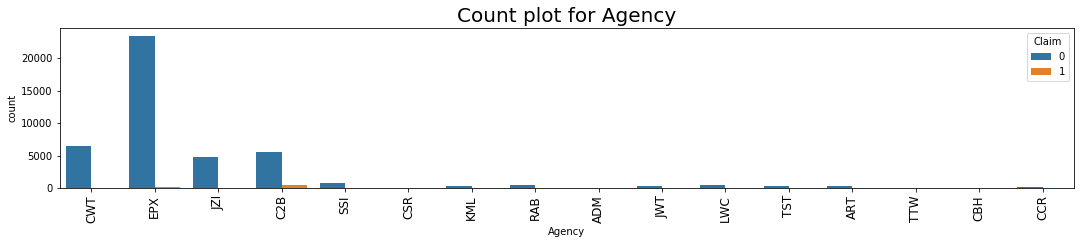

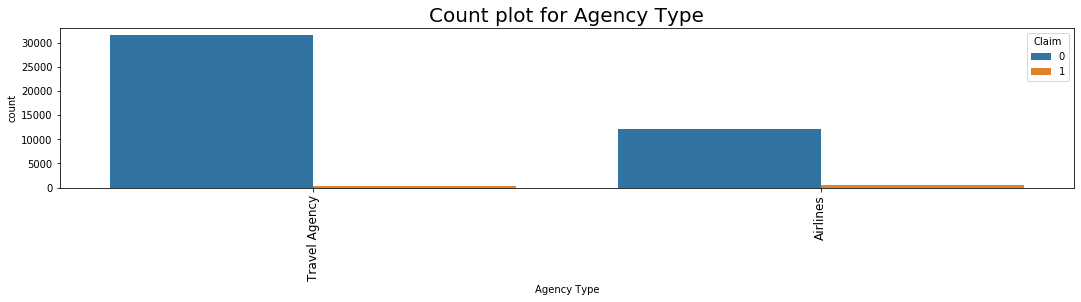

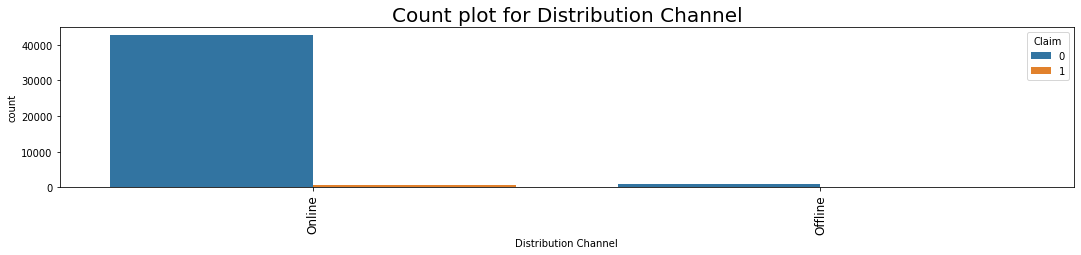

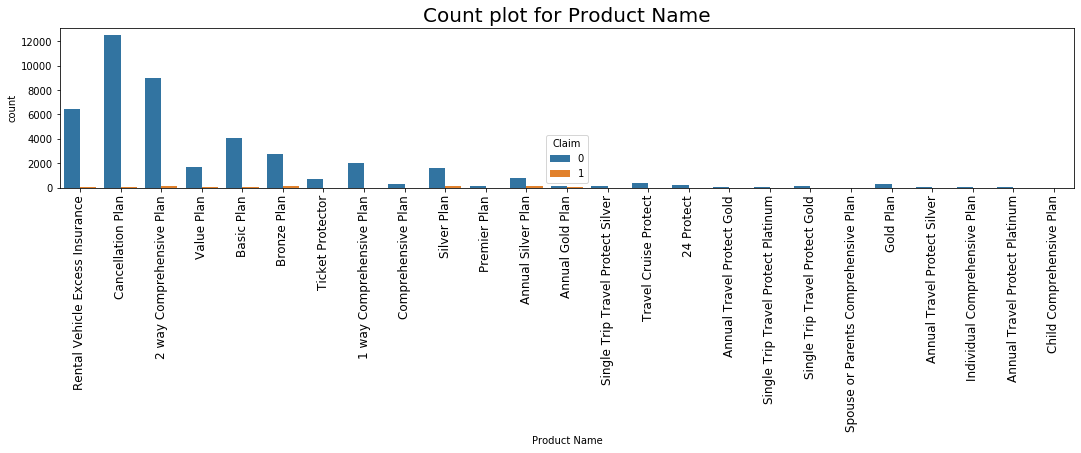

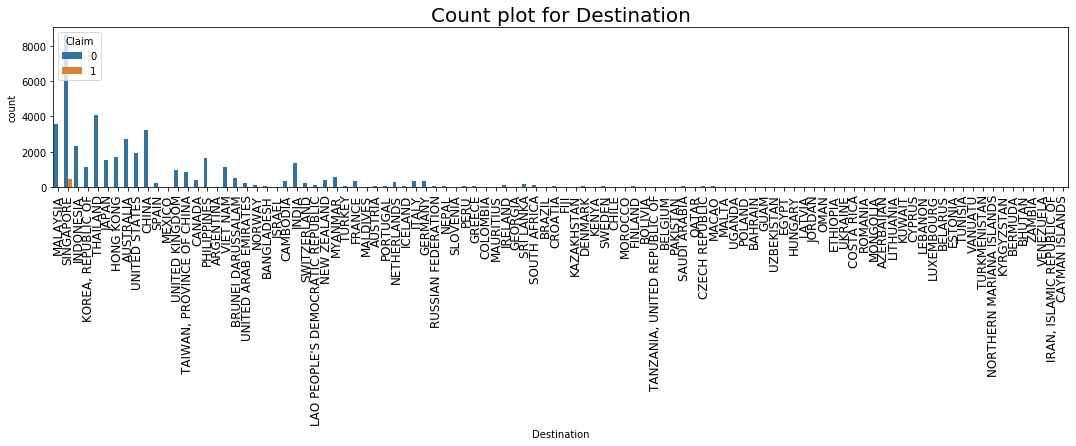

In [24]:
n=1
for j in cat_cols.columns:
    plt.figure(figsize=(40,10))
    plt.subplot(3,2,n)
    sns.countplot(data_train[j],hue=data_train['Claim'])
    plt.title('Count plot for '+j,fontsize=20)
    n+=1
    plt.xticks(rotation=90,fontsize=12)
#     plt.show()

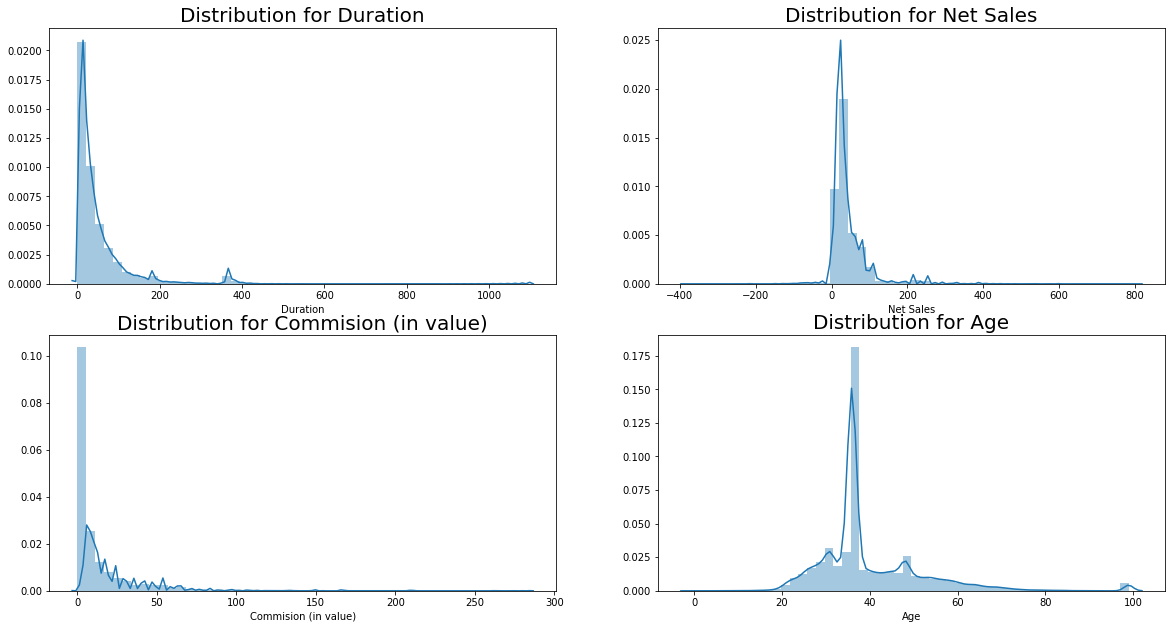

In [25]:
n = 1
plt.figure(figsize = (20,16))
for i in num_cols.columns:
    plt.subplot(3,2,n)
    sns.distplot(data_train[i])
    plt.title('Distribution for '+i,fontsize=20)
    n+=1

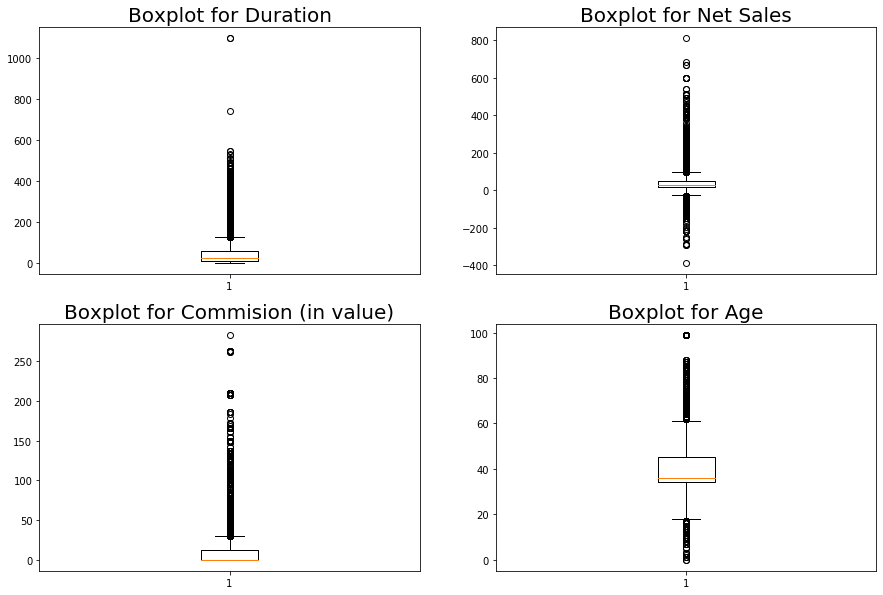

In [26]:
n=1
plt.figure(figsize=(15,10))
for box in num_cols.columns:
    plt.subplot(2,2,n)
    plt.boxplot(num_cols[box])
    plt.title('Boxplot for '+box,fontsize=20)   
    n+=1

In [27]:
cat_cols1=data_test.select_dtypes(['object'])
num_cols1=data_test.select_dtypes(['int64','float64'])

LABEL ENCODING

In [28]:
label_cols = pd.DataFrame()
encoder = LabelEncoder()

# Fit-transform on data
for column in cat_cols:
    label_cols[column] = encoder.fit_transform(cat_cols[column])

In [29]:
label_cols.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,6,1,1,16,56
1,7,1,1,10,79
2,6,1,1,16,56
3,7,1,1,1,38
4,7,1,1,10,47


In [30]:
num_cols.head()

,Duration,Net Sales,Commision (in value),Age
0,7,0.0,17.82,31
1,85,69.0,0.00,36
2,11,19.8,11.88,75
3,16,20.0,0.00,32
4,10,15.0,0.00,29


In [31]:
df1 = pd.concat([label_cols,num_cols], axis=1)

In [32]:
df1.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Duration,Net Sales,Commision (in value),Age
0,6.0,1.0,1.0,16.0,56.0,7.0,0.0,17.82,31.0
1,7.0,1.0,1.0,10.0,79.0,85.0,69.0,0.00,36.0
2,6.0,1.0,1.0,16.0,56.0,11.0,19.8,11.88,75.0
3,7.0,1.0,1.0,1.0,38.0,16.0,20.0,0.00,32.0
4,7.0,1.0,1.0,10.0,47.0,10.0,15.0,0.00,29.0


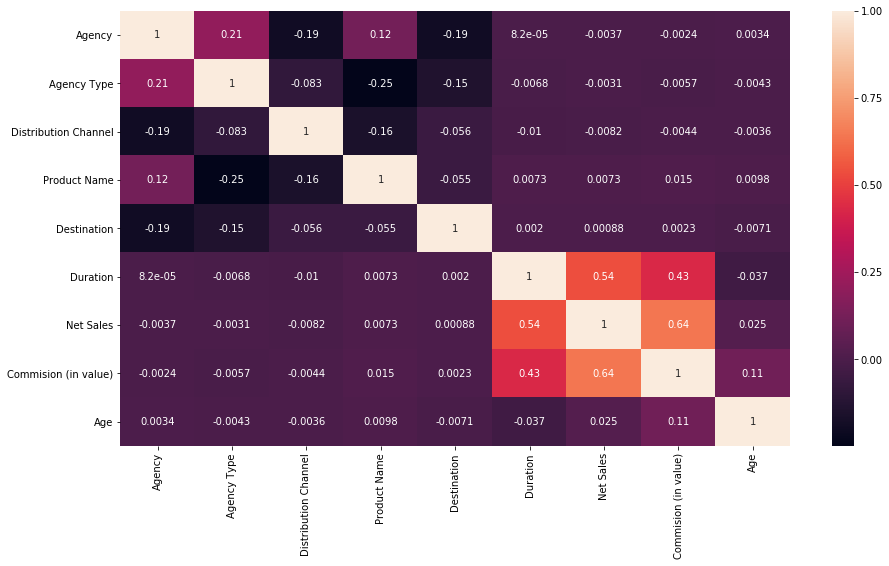

In [33]:
plt.figure(figsize=(15,8))
sns.heatmap(df1.corr(),annot=True)

In [34]:
correlation = df1.corr().unstack()
correlation[(abs(correlation)>0.75) & (abs(correlation) != 1)]

Series([], dtype: float64)

In [35]:
cat_cols = pd.get_dummies(cat_cols) 
cat_cols1 = pd.get_dummies(cat_cols1)

In [36]:
cat_cols.head()

,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,Agency_EPX,Agency_JWT,Agency_JZI,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df1 = pd.concat([num_cols,cat_cols], axis=1)

In [38]:
df1.head()

,Duration,Net Sales,Commision (in value),Age,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,7,0.0,17.82,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,85,69.0,0.00,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,19.8,11.88,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,20.0,0.00,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,15.0,0.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df2 = pd.concat([num_cols1,cat_cols1], axis=1)

In [40]:
#Separating featrue and target
X = df1
y = data_train['Claim']

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[num_cols.columns] = scaler.fit_transform(X[num_cols.columns])   
df2[num_cols1.columns] = scaler.transform(df2[num_cols1.columns])

In [42]:
X.head()

,Duration,Net Sales,Commision (in value),Age,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,0.006393,0.324437,0.062857,0.313131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.077626,0.381985,0.000000,0.363636,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.010046,0.340951,0.041905,0.757576,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.014612,0.341118,0.000000,0.323232,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.009132,0.336947,0.000000,0.292929,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)#, stratify=y)

In [44]:
y_train.value_counts()

0    30515
1      524
Name: Claim, dtype: int64

In [45]:
# Logistic Regression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix, f1_score,recall_score

logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_pred_lr_proba = np.array(pd.DataFrame(logreg.predict_proba(X_test)).iloc[:,1])
logreg.score(X_test,y_test)

0.7850860708110953

In [46]:
precision_lr=precision_score(y_test,y_pred_lr,average='weighted')
recall_lr=recall_score(y_test,y_pred_lr,average='weighted')
f1_lr=f1_score(y_test,y_pred_lr,average='weighted')
roc_lr=roc_auc_score(y_test,y_pred_lr_proba)
print('Report for logistic model\n',classification_report(y_test,y_pred_lr))
print('ROC AUC score for logistic model is ',roc_lr)
print('precision Score for logistic model is',precision_lr)
print('recall Score for logistic model is',recall_lr)
print('f1 Score for logistic model is',f1_lr)

Report for logistic model
               precision    recall  f1-score   support

           0       0.99      0.79      0.88     13091
           1       0.05      0.72      0.10       212

    accuracy                           0.79     13303
   macro avg       0.52      0.75      0.49     13303
weighted avg       0.98      0.79      0.87     13303

ROC AUC score for logistic model is  0.8001026558646802
precision Score for logistic model is 0.9791809738436362
recall Score for logistic model is 0.7850860708110953
f1 Score for logistic model is 0.8655835299048502


In [47]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_lr).ravel()
print('Confusion Matrix for logistic model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for logistic model
tp fp
152 2799 

fn tn
60 10292


In [48]:
# Decision Tree

dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_pred_proba = np.array(pd.DataFrame(dt.predict_proba(X_test)).iloc[:,1])
dt.score(X_test,y_test)

0.9666240697587011

In [49]:
precision_dt=precision_score(y_test,y_pred_dt,average='weighted')
recall_dt=recall_score(y_test,y_pred_dt,average='weighted')
f1_dt=f1_score(y_test,y_pred_dt,average='weighted')
roc_dt=roc_auc_score(y_test,dt_pred_proba)
print('Report for decision tree model\n',classification_report(y_test,y_pred_dt))
print('ROC AUC score for decision tree model is ',roc_dt)
print('precision Score for decision tree model is',precision_dt)
print('recall Score for decision tree model is',recall_dt)
print('f1 Score for decision tree model is',f1_dt)

Report for decision tree model
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     13091
           1       0.05      0.06      0.06       212

    accuracy                           0.97     13303
   macro avg       0.52      0.52      0.52     13303
weighted avg       0.97      0.97      0.97     13303

ROC AUC score for decision tree model is  0.5212590242756439
precision Score for decision tree model is 0.9698549534498881
recall Score for decision tree model is 0.9666240697587011
f1 Score for decision tree model is 0.9682279887347431


In [50]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_dt).ravel()
print('Confusion Matrix for decision tree model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for decision tree model
tp fp
13 245 

fn tn
199 12846


In [51]:
# Random Forest

rfc = RandomForestClassifier(random_state=42)
param_grid = { 
'n_estimators': [10,11,12,13,14],
'max_depth' : [3,4,5,6],
'criterion' :['gini', 'entropy']
}
grid_search_model = GridSearchCV(rfc, param_grid=param_grid, cv=3)
grid_search_model.fit(X_train,y_train)

grid_search_model.best_params_

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10}

In [52]:
rfc1 = RandomForestClassifier(random_state=42,criterion = 'gini',max_depth =3,n_estimators=10, class_weight='balanced')
rfc1.fit(X_train, y_train)
y_pred_rf = rfc1.predict(X_test)
y_pred_rf_proba = np.array(pd.DataFrame(rfc1.predict_proba(X_test)).iloc[:,1])
rfc1.score(X_test,y_test)

0.8543185747575734

In [53]:
precision_rf=precision_score(y_test,y_pred_rf,average='weighted')
recall_rf=recall_score(y_test,y_pred_rf,average='weighted')
f1_rf=f1_score(y_test,y_pred_rf,average='weighted')
roc_rf=roc_auc_score(y_test,y_pred_rf_proba)
print('Report for randomforest model\n',classification_report(y_test,y_pred_rf))
print('ROC AUC score for randomforest model is ',roc_rf)
print('precision Score for randomforest model is',precision_rf)
print('recall Score for randomforest model is',recall_rf)
print('f1 Score for randomforest model is',f1_rf)

Report for randomforest model
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     13091
           1       0.07      0.61      0.12       212

    accuracy                           0.85     13303
   macro avg       0.53      0.73      0.52     13303
weighted avg       0.98      0.85      0.91     13303

ROC AUC score for randomforest model is  0.7805081411253303
precision Score for randomforest model is 0.9778839770602477
recall Score for randomforest model is 0.8543185747575734
f1 Score for randomforest model is 0.9078075842668195


In [54]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_rf).ravel()
print('Confusion Matrix for randomforest model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for randomforest model
tp fp
129 1855 

fn tn
83 11236


In [55]:
# Bagging

bagging_clf = BaggingClassifier(rfc1, random_state=42,n_estimators=100,max_samples=11800)
bagging_clf.fit(X_train,y_train)
y_pred_bagging = bagging_clf.predict(X_test)
y_pred_bagging_proba = np.array(pd.DataFrame(bagging_clf.predict_proba(X_test)).iloc[:,1])
bagging_clf.score(X_test,y_test)

0.8664962790348042

In [56]:
precision_bagging=precision_score(y_test,y_pred_bagging,average='weighted')
recall_bagging=recall_score(y_test,y_pred_bagging,average='weighted')
f1_bagging=f1_score(y_test,y_pred_bagging,average='weighted')
roc_bagging=roc_auc_score(y_test,y_pred_bagging_proba)
print('Report for bagging model\n',classification_report(y_test,y_pred_bagging))
print('ROC AUC score for bagging model is ',roc_bagging)
print('precision Score for bagging model is',precision_bagging)
print('recall Score for bagging model is',recall_bagging)
print('f1 Score for bagging model is',f1_bagging)

Report for bagging model
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     13091
           1       0.07      0.59      0.12       212

    accuracy                           0.87     13303
   macro avg       0.53      0.73      0.53     13303
weighted avg       0.98      0.87      0.91     13303

ROC AUC score for bagging model is  0.7876666671470967
precision Score for bagging model is 0.9778020405628922
recall Score for bagging model is 0.8664962790348042
f1 Score for bagging model is 0.9149357949475867


In [57]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_bagging).ravel()
print('Confusion Matrix for bagging model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for bagging model
tp fp
126 1690 

fn tn
86 11401


In [58]:
# AdaBoost

parameters={'learning_rate':[0.1,0.3,0.6,0.8,1.0],'n_estimators':[50,100,150]}

dt_clf=DecisionTreeClassifier(criterion='gini',random_state = 12,max_depth=1,class_weight='balanced')
ada_clf = AdaBoostClassifier(base_estimator=dt,random_state=42)

clf_model_ada=GridSearchCV(estimator=ada_clf,param_grid=parameters,scoring='roc_auc')
clf_model_ada.fit(X_train,y_train)
y_pred_ada_gs=clf_model_ada.predict(X_test)
y_pred_ada_gs_proba = np.array(pd.DataFrame(clf_model_ada.predict_proba(X_test)).iloc[:,1])
clf_model_ada.score(X_test,y_test)

0.7055108075114258

In [59]:
clf_model_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [60]:
precision_AdaBoost=precision_score(y_test,y_pred_ada_gs,average='weighted')
recall_AdaBoost=recall_score(y_test,y_pred_ada_gs,average='weighted')
f1_AdaBoost=f1_score(y_test,y_pred_ada_gs,average='weighted')
roc_AdaBoost=roc_auc_score(y_test,y_pred_ada_gs_proba)
print('Report for AdaBoost model\n',classification_report(y_test,y_pred_ada_gs))
print('ROC AUC score for AdaBoost model is ',roc_AdaBoost)
print('precision Score for AdaBoost model is',precision_AdaBoost)
print('recall Score for AdaBoost model is',recall_AdaBoost)
print('f1 Score for AdaBoost model is',f1_AdaBoost)

Report for AdaBoost model
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     13091
           1       0.03      0.03      0.03       212

    accuracy                           0.97     13303
   macro avg       0.51      0.51      0.51     13303
weighted avg       0.97      0.97      0.97     13303

ROC AUC score for AdaBoost model is  0.7055097265440897
precision Score for AdaBoost model is 0.9691115877624988
recall Score for AdaBoost model is 0.9707584755318349
f1 Score for AdaBoost model is 0.9699327107680308


In [61]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_ada_gs).ravel()
print('Confusion Matrix for AdaBoost model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for AdaBoost model
tp fp
6 183 

fn tn
206 12908


In [62]:
# Xgb

parameters={'learning_rate':[0.1,0.3,0.6,0.8,1.0],
            'max_depth':range(1,4),'n_estimators':[50,100,150]}
xgb_clf=XGBClassifier(random_state=42,scale_pos_weight = 34881/589)

clf_model_xgb=GridSearchCV(estimator=xgb_clf,param_grid=parameters,scoring='roc_auc')
clf_model_xgb.fit(X_train,y_train)
y_pred_xgb_gs=clf_model_xgb.predict(X_test)
y_pred_xgb_gs_proba = np.array(pd.DataFrame(clf_model_xgb.predict_proba(X_test)).iloc[:,1])
clf_model_xgb.score(X_test,y_test)

0.7998021469452584

In [63]:
clf_model_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}

In [64]:
xgb_clf=XGBClassifier(random_state=42,scale_pos_weight = 34881/589,learning_rate= 0.1, max_depth= 1, n_estimators= 150)
xgb_clf.fit(X_train,y_train)
xgb_pred = xgb_clf.predict(X_test)

In [65]:
precision_xgb=precision_score(y_test,y_pred_xgb_gs,average='weighted')
recall_xgb=recall_score(y_test,y_pred_xgb_gs,average='weighted')
f1_xgb=f1_score(y_test,y_pred_xgb_gs,average='weighted')
roc_xgb=roc_auc_score(y_test,y_pred_xgb_gs_proba)
print('Report for xgb model\n',classification_report(y_test,y_pred_xgb_gs))
print('ROC AUC score for xgb model is ',roc_xgb)
print('precision Score for xgb model is',precision_xgb)
print('recall Score for xgb model is',recall_xgb)
print('f1 Score for xgb model is',f1_xgb)

Report for xgb model
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     13091
           1       0.05      0.64      0.10       212

    accuracy                           0.81     13303
   macro avg       0.52      0.73      0.50     13303
weighted avg       0.98      0.81      0.88     13303

ROC AUC score for xgb model is  0.7998021469452584
precision Score for xgb model is 0.9779791319031285
recall Score for xgb model is 0.8144027662933173
f1 Score for xgb model is 0.8838369319985139


In [66]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_xgb_gs).ravel()
print('Confusion Matrix for xgb model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for xgb model
tp fp
136 2393 

fn tn
76 10698


In [67]:
# SVC

svc = SVC(class_weight='balanced',probability=True)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_pred_proba = svc.predict_proba(X_test)
svc.score(X_test,y_test)

0.8455235661129069

In [68]:
precision_SVC=precision_score(y_test,svc_pred,average='weighted')
recall_SVC=recall_score(y_test,svc_pred,average='weighted')
f1_SVC=f1_score(y_test,svc_pred,average='weighted')
roc_SVC=roc_auc_score(y_test,svc_pred_proba[:,1])
print('Report for SVC model\n',classification_report(y_test,svc_pred))
print('ROC AUC score for SVC model is ',roc_SVC)
print('precision Score for SVC model is',precision_SVC)
print('recall Score for SVC model is',recall_SVC)
print('f1 Score for SVC model is',f1_SVC)

Report for SVC model
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     13091
           1       0.06      0.63      0.12       212

    accuracy                           0.85     13303
   macro avg       0.53      0.74      0.52     13303
weighted avg       0.98      0.85      0.90     13303

ROC AUC score for SVC model is  0.7847208509951384
precision Score for SVC model is 0.9782171312818675
recall Score for SVC model is 0.8455235661129069
f1 Score for SVC model is 0.9026238135646832


In [69]:
tn,fp,fn,tp = confusion_matrix(y_test,svc_pred).ravel()
print('Confusion Matrix for SVC model')
print('tp','fp')
print(tp,fp,'\n')
print('fn','tn')
print(fn,tn)

Confusion Matrix for SVC model
tp fp
134 1977 

fn tn
78 11114


In [70]:
Models = ['Logistic Regression','Decision Tree','Random Forest','Bagging','AdaBoost','xgb','SVC']
Precision_score = [precision_lr, precision_dt, precision_rf, precision_bagging, precision_AdaBoost, precision_xgb, precision_SVC]
F1_score = [f1_lr, f1_dt, f1_rf, f1_bagging, f1_AdaBoost, f1_xgb, f1_SVC]
Recall_score = [recall_lr, recall_dt, recall_rf, recall_bagging, recall_AdaBoost, recall_xgb, recall_SVC]
ROC_score = [roc_lr, roc_dt, roc_rf, roc_bagging, roc_AdaBoost, roc_xgb, roc_SVC]
pd.DataFrame({'Models': Models, 'Precision Score': Precision_score,'Recall Score': Recall_score ,'F1 Score' : F1_score,'ROC score': ROC_score })

,Models,Precision Score,Recall Score,F1 Score,ROC score
0,Logistic Regression,0.979181,0.785086,0.865584,0.800103
1,Decision Tree,0.969855,0.966624,0.968228,0.521259
2,Random Forest,0.977884,0.854319,0.907808,0.780508
3,Bagging,0.977802,0.866496,0.914936,0.787667
4,AdaBoost,0.969112,0.970758,0.969933,0.705510
5,xgb,0.977979,0.814403,0.883837,0.799802
6,SVC,0.978217,0.845524,0.902624,0.784721


In [71]:
fpr1, tpr1 ,threshold1 = roc_curve(y_test,y_pred_lr_proba)
fpr2, tpr2 ,threshold2 = roc_curve(y_test,dt_pred_proba)
fpr3, tpr3 ,threshold3 = roc_curve(y_test,y_pred_rf_proba)
fpr4, tpr4 ,threshold4 = roc_curve(y_test,y_pred_bagging_proba)
fpr5, tpr5 ,threshold5 = roc_curve(y_test,y_pred_ada_gs_proba)
fpr6, tpr6 ,threshold6 = roc_curve(y_test,y_pred_xgb_gs_proba)
fpr7, tpr7 ,threshold7 = roc_curve(y_test,svc_pred_proba[:,1])

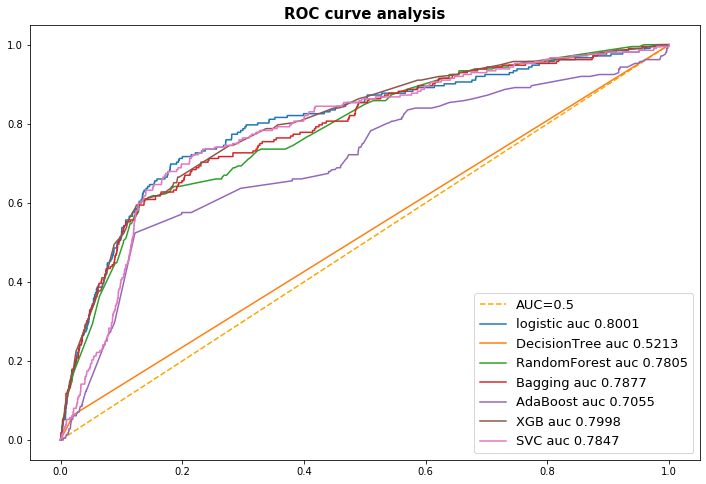

In [72]:
plt.figure(figsize=(12,8))
plt.title('ROC curve analysis', fontweight='bold', fontsize=15)
plt.plot([0,1], [0,1], color='orange', linestyle='--',label='AUC=0.5')
plt.legend(loc='best')

plt.plot(fpr1,tpr1,label='logistic auc '+"%.4f" % roc_auc_score(y_test,y_pred_lr_proba))
plt.legend(loc='best')

plt.plot(fpr2,tpr2,label='DecisionTree auc '+"%.4f" % roc_auc_score(y_test,dt_pred_proba))
plt.legend(prop={'size':13}, loc='best')

plt.plot(fpr3,tpr3,label='RandomForest auc '+"%.4f" % roc_auc_score(y_test,y_pred_rf_proba))
plt.legend(prop={'size':13}, loc='best')

plt.plot(fpr4,tpr4,label='Bagging auc '+"%.4f" % roc_auc_score(y_test,y_pred_bagging_proba))
plt.legend(prop={'size':13}, loc='best')

plt.plot(fpr5,tpr5,label='AdaBoost auc '+"%.4f" % roc_auc_score(y_test,y_pred_ada_gs_proba))
plt.legend(prop={'size':13}, loc='best')

plt.plot(fpr6,tpr6,label='XGB auc '+"%.4f" % roc_auc_score(y_test,y_pred_xgb_gs_proba))
plt.legend(prop={'size':13}, loc='best')

plt.plot(fpr7,tpr7,label='SVC auc '+"%.4f" % roc_auc_score(y_test,svc_pred_proba[:,1]))
plt.legend(prop={'size':13}, loc='best')

In [73]:
y_pred_test = logreg.predict(df2)
df3 = pd.DataFrame({'Claim':np.array(y_pred_test)})

In [74]:
test_dataset = pd.concat([data_test1,df3],axis=1,sort=False)
test_dataset.head()

,ID,Claim
0,25902,1
1,19535,0
2,43717,0
3,48271,0
4,52318,0


In [75]:
test_dataset['Claim'].value_counts()

0    10015
1     2646
Name: Claim, dtype: int64

In [76]:
# Submission CSV file
submit = test_dataset
submit.to_csv('Final submission.csv', index = False)